In [137]:
%load_ext autoreload
%autoreload 2
from src.chem_draw import draw_rxn_svg, draw_pwy_svg
from src.utils import sort_x_by_y, ensure_dirs, load_json
from svgutils import compose as sc
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
# Params
starters = 'ccm_v0'
targets = 'mvacid'
generations = 4

expansion_dir = '../data/processed_expansions/'
fn = f"{starters}_to_{targets}_gen_{generations}_tan_sample_1_n_samples_1000.pk" # Expansion file name
rxns_path = expansion_dir + 'predicted_reactions_' + fn
paths_path = expansion_dir + 'paths_' + fn

In [139]:
# Load reactions and paths
with open(rxns_path, 'rb') as f:
    pred_rxns = pickle.load(f)

with open(paths_path, 'rb') as f:
    paths = pickle.load(f)

In [140]:
# Count how many pathways have full info

for k,v in paths.items():
    n_paths_w_full_info = 0
    for p in v:
        path_full_info = []
        for rh in p.rhashes:
            full_info = False
            for elt in pred_rxns[rh].known_rxns:
                if elt[0] is not None:
                    full_info = True
                    break

            path_full_info.append(full_info)
        
        if all(path_full_info):
            n_paths_w_full_info += 1

    print(k, f"{n_paths_w_full_info} / {len(v)} paths w/ full info")


('fumarate', 'mvacid') 414 / 557 paths w/ full info
('succinate', 'mvacid') 12 / 17 paths w/ full info
('acetate', 'mvacid') 2 / 2 paths w/ full info
('pyruvate', 'mvacid') 3 / 3 paths w/ full info


In [141]:
# Sort known reactions by average (could alter the sort by value)
for k in pred_rxns.keys():
    pred_rxns[k].sort_known_rxns()

In [142]:
# Set prc mcs attribute for each path by averaging over 
# known reactions
for st_pair in paths:
    for p in paths[st_pair]:
        p.compute_mean_prc_mcs(pred_rxns)

In [143]:
# Readin uniprot ids
# TODO: move up in pipeline

brenda_uniprot = load_json('../data/mapping/brenda_uniprot.json')
mc_uniprot = load_json('../data/mapping/metacyc_uniprot.json')
key_repeats = set(brenda_uniprot.keys()) & set(mc_uniprot.keys())
print(len(key_repeats))
uniprot = {**mc_uniprot, **brenda_uniprot}

0


In [144]:
# First filter by mdf and min prc_mcs then sort by mean prc_mcs

min_thresh = 0.05
sheets = []
sheetnames = []

for st_pair in paths.keys():

    # TODO: write mdf getter that returns -np.inf to make this kind of logic easier 
    # Remove zero mins
    filtered_idxs = []
    for i in range(len(paths[st_pair])):
        if paths[st_pair][i].mdf:
            if (paths[st_pair][i].mdf > 0) & (paths[st_pair][i].min_mcs() > min_thresh):
                filtered_idxs.append(i)

    # filtered_idxs = [i for i in range(len(paths[st_pair])) if (paths[st_pair][i].mdf > 0) & (paths[st_pair][i].min_mcs() > min_thresh)]
    
    if len(filtered_idxs) > 0:
        # Get mean prc_mcs of non-zero min paths
        mean_prc_mcs = []
        for idx in filtered_idxs:
            mean_prc_mcs.append(paths[st_pair][idx].mean_mcs())

        mean_sorted_idxs, mean_prc_mcs = sort_x_by_y(filtered_idxs, mean_prc_mcs, reverse=True)
        print(f"{st_pair} {len(filtered_idxs)} paths with mdf > 0 and min mcs > {min_thresh}")

        # Generate pwy svgs & csv
        print("Generating svgs & csv")
        headers = ['starter', 'target', 'mdf', 'mcs'] + [f"uniprot_{g+1}" for g in range(generations)]
        to_df = {k: [] for k in headers}
        pwy_svg_outdir = f"../artifacts/pwy_svgs/{fn[:-3]}/{'_'.join(st_pair)}/"
        ensure_dirs(pwy_svg_outdir)

        for i, pwy_idx in enumerate(mean_sorted_idxs):
            this_path = paths[st_pair][pwy_idx]

            # svg (mainly)
            sma_hash_pairs = []
            this_rhashes = this_path.rhashes
            for r, this_rhash in enumerate(this_rhashes):
                this_rxn = pred_rxns[this_rhash]
                sma_hash_pairs.append([(this_rxn.smarts, this_rhash), (this_rxn.known_rxns[0][1], hash(this_rxn.known_rxns[0][1]))])
                
                # Uniprot ids
                kr = this_rxn.known_rxns[0] # Take only the kr you display in pdf for now
                if kr[2] in uniprot:
                    to_df[f"uniprot_{r+1}"].append(uniprot[kr[2]][-1]) # Add uniprots to csv
                else:
                    to_df[f"uniprot_{r+1}"].append('')


            # o for oops, need better way.. didn't know there
            # were <n step pathways in n generation expansions
            if len(this_rhashes) < generations:
                for o in range(len(this_rhashes), generations):
                    to_df[f"uniprot_{o+1}"].append('')
            
            outpath = pwy_svg_outdir + f"{i:03}_{pwy_idx}.svg"
            draw_pwy_svg(sma_hash_pairs, outpath)

            # Add infor to csv
            to_df['starter'].append(st_pair[0])
            to_df['target'].append(st_pair[1])
            to_df['mdf'].append(this_path.mdf)
            to_df['mcs'].append(this_path.mean_mcs())


        # Make df for this st pair
        sheets.append(pd.DataFrame(to_df))
        sheetnames.append("_".join(st_pair))


        # Convert svgs to pdfs
        print("Generating pdfs")
        tmp_pdf_outdir = f"../artifacts/tmp_pdfs/{fn[:-3]}/{'_'.join(st_pair)}/"
        ensure_dirs(tmp_pdf_outdir)
        for i, pwy_idx in enumerate(mean_sorted_idxs):
            cmd = ["inkscape", f"--export-pdf={tmp_pdf_outdir}{i:03}_{pwy_idx}.pdf", f"{pwy_svg_outdir}{i:03}_{pwy_idx}.svg"]
            subprocess.run(cmd)

        # Concatenate pdfs
        print("Concatenating pdfs")
        pwy_pdf_outdir = f"../artifacts/pwy_pdfs/{fn[:-3]}/"
        ensure_dirs(pwy_pdf_outdir)
        cat_pdf_fn = pwy_pdf_outdir + '_'.join(st_pair) + '.pdf'
        individual_pwys = sorted([f"{i:03}_{pwy_idx}.pdf" for i, pwy_idx in enumerate(mean_sorted_idxs)])
        individual_pwys = [tmp_pdf_outdir + elt for elt in individual_pwys]
        
        cmd = ["pdfunite", *individual_pwys, cat_pdf_fn]
        subprocess.run(cmd)

# Concatenate sheets into xls
print("Saving xlsx")
if len(sheets) > 0:
    writer = pd.ExcelWriter(f"../artifacts/pwy_xls/{fn[:-3]}" + '.xlsx') # Arbitrary output name
    for i, df in enumerate(sheets):
        df.to_excel(writer,sheet_name=sheetnames[i])
    writer.save()

# Remove stuff
dirs = ['../artifacts/' + elt for elt in ['tmp_pdfs', 'rxn_svgs', 'pwy_svgs', 'mol_svgs']]
for elt in dirs:
    subprocess.run([f"rm -r {elt}/*"], shell=True)

('fumarate', 'mvacid') 93 paths with mdf > 0 and min mcs > 0.05
Generating svgs & csv
Generating pdfs


Gtk-Message: 10:52:50.416: Failed to load module "gail"
Gtk-Message: 10:52:50.416: Failed to load module "atk-bridge"

(inkscape:35232): Gtk-WARNING **: 10:52:50.423: Unable to locate theme engine in module_path: "pixmap",

(inkscape:35232): Gtk-WARNING **: 10:52:50.424: Unable to locate theme engine in module_path: "adwaita",

(inkscape:35232): Gtk-WARNING **: 10:52:50.424: Unable to locate theme engine in module_path: "pixmap",

(inkscape:35232): Gtk-WARNING **: 10:52:50.425: Unable to locate theme engine in module_path: "pixmap",

(inkscape:35232): Gtk-WARNING **: 10:52:50.425: Unable to locate theme engine in module_path: "pixmap",

(inkscape:35232): Gtk-WARNING **: 10:52:50.425: Unable to locate theme engine in module_path: "pixmap",

(inkscape:35232): Gtk-WARNING **: 10:52:50.425: Unable to locate theme engine in module_path: "pixmap",

(inkscape:35232): Gtk-WARNING **: 10:52:50.426: Unable to locate theme engine in module_path: "pixmap",

(inkscape:35232): Gtk-WARNING **: 10:52:

Concatenating pdfs
('pyruvate', 'mvacid') 2 paths with mdf > 0 and min mcs > 0.05
Generating svgs & csv
Generating pdfs


Gtk-Message: 10:54:37.177: Failed to load module "gail"
Gtk-Message: 10:54:37.177: Failed to load module "atk-bridge"

(inkscape:36125): Gtk-WARNING **: 10:54:37.181: Unable to locate theme engine in module_path: "pixmap",

(inkscape:36125): Gtk-WARNING **: 10:54:37.182: Unable to locate theme engine in module_path: "adwaita",

(inkscape:36125): Gtk-WARNING **: 10:54:37.182: Unable to locate theme engine in module_path: "pixmap",

(inkscape:36125): Gtk-WARNING **: 10:54:37.182: Unable to locate theme engine in module_path: "pixmap",

(inkscape:36125): Gtk-WARNING **: 10:54:37.183: Unable to locate theme engine in module_path: "pixmap",

(inkscape:36125): Gtk-WARNING **: 10:54:37.183: Unable to locate theme engine in module_path: "pixmap",

(inkscape:36125): Gtk-WARNING **: 10:54:37.183: Unable to locate theme engine in module_path: "pixmap",

(inkscape:36125): Gtk-WARNING **: 10:54:37.183: Unable to locate theme engine in module_path: "pixmap",

(inkscape:36125): Gtk-WARNING **: 10:54:

Concatenating pdfs
Saving xlsx


In [63]:
# Single st_pair
from rdkit import Chem
from rdkit.Chem import AllChem
st_pair = ('succinate', 'hopa')
min_thresh = 0.05

# TODO: write mdf getter that returns -np.inf to make this kind of logic easier 
# Remove zero mins
filtered_idxs = []
for i in range(len(paths[st_pair])):
    if paths[st_pair][i].mdf:
        if (paths[st_pair][i].mdf > 0) & (paths[st_pair][i].min_mcs() > min_thresh):
            filtered_idxs.append(i)

# filtered_idxs = [i for i in range(len(paths[st_pair])) if (paths[st_pair][i].mdf > 0) & (paths[st_pair][i].min_mcs() > min_thresh)]

if len(filtered_idxs) > 0:
    # Get mean prc_mcs of non-zero min paths
    mean_prc_mcs = []
    for idx in filtered_idxs:
        mean_prc_mcs.append(paths[st_pair][idx].mean_mcs())

    mean_sorted_idxs, mean_prc_mcs = sort_x_by_y(filtered_idxs, mean_prc_mcs, reverse=True)
    print(f"{st_pair} {len(filtered_idxs)} paths with mdf > 0 and min mcs > {min_thresh}")

('succinate', 'hopa') 18 paths with mdf > 0 and min mcs > 0.05


In [109]:
mean_sorted_idxs[0]

140

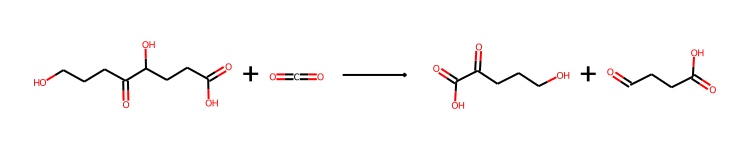

In [118]:
rhash = paths[st_pair][mean_sorted_idxs[0]].rhashes[3]
kr = pred_rxns[rhash].known_rxns[3]
AllChem.ReactionFromSmarts(pred_rxns[rhash].smarts, useSmiles=True)

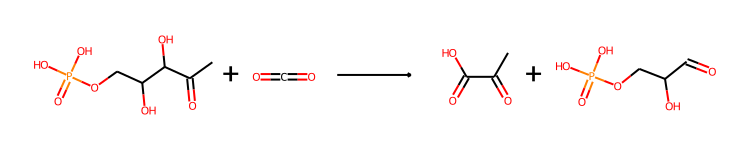

In [119]:

AllChem.ReactionFromSmarts(kr[1], useSmiles=True)

In [120]:
uniprot[kr[2]]

[{'CARBON-DIOXIDE:0': 'O=C=O',
  'DEOXYXYLULOSE-5P:0': 'CC(=O)[C@@H](O)[C@H](O)COP(=O)(O)O'},
 {'GAP:0': 'O=C[C@H](O)COP(=O)(O)O', 'PYRUVATE:0': 'CC(=O)C(=O)O'},
 'A0AIG6,A0AYZ0,A0JVG9,A0KNF9,A0KZA9,A0L6H3,A0PT40,A0Q0A4,A0Q6B9,A0QIL6,A0QW19,A0RMN5,A1A890,A1JNR7,A1K4R0,A1KM20,A1KS32,A1R5N7,A1RLV3,A1S8D4,A1SKM6,A1SWW6,A1T7Z0,A1TNR1,A1UF44,A1URW6,A1VE69,A1VMD7,A1VY40,A1W4U9,A1WN06,A2BR27,A2BWN6,A2C220,A2C9X1,A2SJ46,A3D2B2,A3MYS9,A3NMF6,A3P7W4,A3PCV0,A3PYK6,A3QGN9,A4FAQ5,A4IQR7,A4IXW5,A4QEQ9,A4SDG1,A4SJP9,A4TCS5,A4TPG2,A4VQS8,A4W791,A4XZ25,A4Y4X0,A4YQ36,A5D2Z6,A5EEQ0,A5F331,A5FRB9,A5GL34,A5GTT4,A5ILK2,A5N7J2,A5U634,A5UC51,A5UEV6,A5V6A9,A5VP09,A5VXW9,A6L175,A6LFB9,A6LU48,A6Q1Z6,A6T5F3,A6V058,A6VUE5,A6WL04,A6WWC4,A7BKB8,A7FLE4,A7GSJ5,A7H552,A7H9E8,A7I2V7,A7IPK6,A7MFG0,A7MYC6,A7NCA4,A7Z6J5,A7ZIH3,A7ZX72,A8AK34,A8EWN0,A8FF11,A8FKB0,A8FYL0,A8G4R9,A8GAP2,A8H6X1,A8IBS1,A8L0K9,A8MFI7,A9BAC1,A9IQP2,A9ITB0,A9KMB8,A9KTL5,A9M1G3,A9M8W0,A9MM42,A9MX09,A9QZS3,A9VGD1,A9WRA9,B0B7P9,B0BBW4,B0BSL0,B0C8J3,B0C

In [113]:
kr

[[0.6923076923076923, 1.0],
 'CC(O)C(=O)CCC(=O)O.O=C=O>>CC=O.O=C(O)CCC(=O)C(=O)O',
 '2.2.1.9_07']

In [117]:
[(i, elt[0], uniprot[elt[2]][-1]) for i, elt in enumerate(pred_rxns[rhash].known_rxns) if elt[2] in uniprot]

[(3,
  [0.5384615384615384, 1.0],
  'A0AIG6,A0AYZ0,A0JVG9,A0KNF9,A0KZA9,A0L6H3,A0PT40,A0Q0A4,A0Q6B9,A0QIL6,A0QW19,A0RMN5,A1A890,A1JNR7,A1K4R0,A1KM20,A1KS32,A1R5N7,A1RLV3,A1S8D4,A1SKM6,A1SWW6,A1T7Z0,A1TNR1,A1UF44,A1URW6,A1VE69,A1VMD7,A1VY40,A1W4U9,A1WN06,A2BR27,A2BWN6,A2C220,A2C9X1,A2SJ46,A3D2B2,A3MYS9,A3NMF6,A3P7W4,A3PCV0,A3PYK6,A3QGN9,A4FAQ5,A4IQR7,A4IXW5,A4QEQ9,A4SDG1,A4SJP9,A4TCS5,A4TPG2,A4VQS8,A4W791,A4XZ25,A4Y4X0,A4YQ36,A5D2Z6,A5EEQ0,A5F331,A5FRB9,A5GL34,A5GTT4,A5ILK2,A5N7J2,A5U634,A5UC51,A5UEV6,A5V6A9,A5VP09,A5VXW9,A6L175,A6LFB9,A6LU48,A6Q1Z6,A6T5F3,A6V058,A6VUE5,A6WL04,A6WWC4,A7BKB8,A7FLE4,A7GSJ5,A7H552,A7H9E8,A7I2V7,A7IPK6,A7MFG0,A7MYC6,A7NCA4,A7Z6J5,A7ZIH3,A7ZX72,A8AK34,A8EWN0,A8FF11,A8FKB0,A8FYL0,A8G4R9,A8GAP2,A8H6X1,A8IBS1,A8L0K9,A8MFI7,A9BAC1,A9IQP2,A9ITB0,A9KMB8,A9KTL5,A9M1G3,A9M8W0,A9MM42,A9MX09,A9QZS3,A9VGD1,A9WRA9,B0B7P9,B0BBW4,B0BSL0,B0C8J3,B0CKC0,B0JL88,B0KL79,B0RC26,B0T3X7,B0TEJ5,B0TQ36,B0U0B3,B0U3E1,B0UUA4,B0V710,B0VQB8,B1HRX4,B1I3J6,B1J029,B1J3G4,B1JID8,B1K3S9,B1KQ